In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import os
import matplotlib.pyplot as plt
import scipy
from scipy import signal

# Derive ON Signatures

In [140]:
SIG_SIZE = 90 # 1 sec contains 30 samples ; 3 seconds 90 samples.
THRSHLD =30
db = np.array([])
name = []

In [141]:
appliances = ['ceilingfan','drill', 'fan', 'hairdryer', 'heater', 'induction', 'iron', 'spinner', 'toaster', 'washing machine']

for appliance_name in appliances:
    data = pd.read_csv(f'../{appliance_name}.txt')
    data['Active Power']= abs(data['Active Power'])
    data['T'] = pd.to_datetime(data['T'])
    data = data.set_index(data['T'])
    data =  data.resample('33ms').mean()
    data = data.dropna()
    data = scipy.signal.medfilt(data['Active Power'], kernel_size=None)
    dbydx = np.gradient(data)
    on_events = []
    for idx,x in enumerate(dbydx):
        if x> THRSHLD:
            on_events.append(idx)
    for x in on_events:
        sig = data[x:x+SIG_SIZE]
        if len(sig) == SIG_SIZE:
            db = np.append(db,sig,axis = 0)
            name.append(f'{appliance_name}')

In [142]:
db = db.reshape((db.shape[0]//SIG_SIZE,SIG_SIZE))

In [143]:
len(db),db.shape

(1841, (1841, 90))

# Using Simple Models

In [144]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

from sklearn.model_selection import train_test_split

X = db
y = name

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

clf.fit(X_train,y_train)

preds = clf.predict(X_test)==y_test

print(f'Total number of predictions = {preds.size}\n',
      f'Number of {np.unique(preds,return_counts=True)[0][0]} predictions = {np.unique(preds,return_counts=True)[1][0]}\n',
      f'Number of {np.unique(preds,return_counts=True)[0][1]} predictions= {np.unique(preds,return_counts=True)[1][1]}\n',
      f'Accuracy = {(np.unique(preds,return_counts=True)[1][1])/(preds.size)*100:.2f}%')
print(np.unique(preds))

Total number of predictions = 369
 Number of False predictions = 13
 Number of True predictions= 356
 Accuracy = 96.48%
[False  True]


# Create Dummy Data

In [145]:
from numpy import random

In [146]:
length = 27000

In [205]:
vamp = (np.array([4]*length))
for ix, appliance_name in enumerate(appliances):
    data = pd.read_csv(f'../{appliance_name}.txt')
    data['Active Power']= abs(data['Active Power'])
    data['T'] = pd.to_datetime(data['T'])
    data = data.set_index(data['T'])
    data =  data.resample('33ms').mean()
    data = data.dropna()
    data = scipy.signal.medfilt(data['Active Power'], kernel_size=None)
    dbydx =(np.gradient(data))
    on_events = []
    for idx,x in enumerate(dbydx):
        if x> THRSHLD:
            on_events.append(idx)
    for e in on_events:
        if data[e-1] < 10:
            x=e
            break
    mltplr = 2000*(1 + ix)
    sig = data[x:x+SIG_SIZE]
    if len(sig) == SIG_SIZE:
        sig = np.array(sig,dtype=float)
        _ = sig[-1]
        sig = np.append(sig,np.array([_]*(length-SIG_SIZE)))
        sig[2500:] = 0
        vamp[mltplr:] = np.add(vamp[mltplr:],sig[:(length-mltplr)])

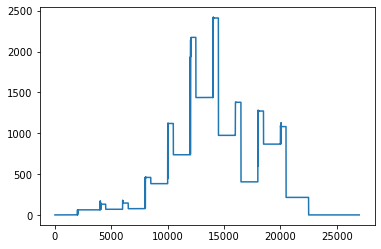

In [206]:
plt.plot(vamp);

pd.Series(vamp).to_csv('../track_test.txt',index = False)

In [207]:
vamp_db = np.array([])
data = scipy.signal.medfilt(vamp, kernel_size=None)
dbydx = (np.gradient(data))
on_events = []
for idx,x in enumerate(dbydx):
    if x > THRSHLD:
        on_events.append(idx)
for x in on_events:
    sig = data[x:x+SIG_SIZE]
    sig = sig - data[x-270:x].mean()
    if len(sig) == SIG_SIZE:
        vamp_db = np.append(vamp_db, sig, axis = 0)

In [208]:
vamp_db = vamp_db.reshape((vamp_db.shape[0]//SIG_SIZE,SIG_SIZE))

In [209]:
vamp_db.shape

(55, 90)

# Major Categorical Classification

In [210]:
test_preds = clf.predict(vamp_db)

In [219]:
df = pd.DataFrame({'Location':on_events,
             'Prediction': test_preds,
                  'actual':'na'})

In [220]:
for idx, x in enumerate(df['Location']):
    if x < 4000:
#         df.loc[[0], ['Country']]
        df.loc[[idx],["actual"]] = appliances[0]
    elif x < 6000 and x >= 4000:
        df.loc[[idx],["actual"]] = appliances[1]
    elif x < 8000 and x >= 6000:
        df.loc[[idx],["actual"]] = appliances[2]
    elif x < 10000 and x >= 8000:
        df.loc[[idx],["actual"]] = appliances[3]
    elif x < 12000 and x >= 10000:
        df.loc[[idx],["actual"]] = appliances[4]
    elif x < 14000 and x >= 12000:
        df.loc[[idx],["actual"]] = appliances[5]
    elif x < 16000 and x >= 14000:
        df.loc[[idx],["actual"]] = appliances[6]
    elif x < 18000 and x >= 16000:
        df.loc[[idx],["actual"]] = appliances[7]
    elif x < 20000 and x >= 18000:
        df.loc[[idx],["actual"]] = appliances[8]
    elif x < 22000 and x >= 20000:
        df.loc[[idx],["actual"]] = appliances[9]

In [221]:
df

,Location,Prediction,actual
0,2000,ceilingfan,ceilingfan
1,2001,ceilingfan,ceilingfan
2,4000,drill,drill
3,4001,drill,drill
4,4019,drill,drill
5,4084,ceilingfan,drill
6,4085,ceilingfan,drill
7,6000,fan,fan
8,6001,fan,fan
9,8000,hairdryer,hairdryer


In [214]:
test_preds_proba = clf.predict_proba(vamp_db)

In [215]:
pd.DataFrame(test_preds_proba,columns=appliances)

,ceilingfan,drill,fan,hairdryer,heater,induction,iron,spinner,toaster,washing machine
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.02,0.92,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.05,0.86,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.01
4,0.01,0.82,0.16,0.00,0.00,0.00,0.00,0.01,0.00,0.00
5,0.87,0.06,0.02,0.00,0.00,0.03,0.00,0.02,0.00,0.00
6,0.88,0.05,0.02,0.00,0.00,0.03,0.00,0.02,0.00,0.00
7,0.01,0.18,0.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.18,0.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


# Derive Signatures to train local database
* **Use signatures with high probability and club them together if they are running contagiously (tracking might help) and train the local model**
* **Once trained rerun the mains data to predict via local model**
* **Ask to name the clubbed signatures only once**

In [23]:
derived_db = np.array([])

In [24]:
for idx, x in enumerate(test_preds_proba):
    if x.max()<0.80:
        pos = on_events[idx]
        derived_sig = vamp[pos:pos+SIG_SIZE]
        if len(derived_sig) == SIG_SIZE:
            derived_db = np.append(derived_db,derived_sig,axis = 0)

derived_db = derived_db.reshape((derived_db.shape[0]//90,90))

In [25]:
derived_db.shape

(0, 90)

In [26]:
name = []
for x in derived_db:
    plt.plot(x)
    plt.show()
    new_sig = input('name this signal')
    name.append(new_sig)

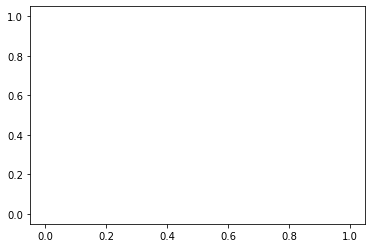

In [27]:
plt.plot(derived_db);

In [28]:
(vamp_db.shape)

(106, 90)